# Full Problem

This notebook compares results from random search and Bayesian search for a 6D problem on the first patient.

## Clinical Goals (Approved Plan)

idx | Name | Description | Type | GoalCriteria | AcceptanceLevel | ParameterValue
-|-|-|-|-|-|-
19 | PTV | At least 95 % volume at 4800 cGy dose | VolumeAtDose | AtLeast | 0.95 | 4800
20 | PTV | At least 99 % volume at 4320 cGy dose | VolumeAtDose | AtLeast | 0.99 | 4320
11 | SpinalCanal |  At most 2080 cGy dose at 0.35 cm$^3$ volume | DoseAtAbsoluteVolume| AtMost | 2080 | 0.35
9 | Lungs | At most 10 % volume at 2000 cGy dose | VolumeAtDose | AtMost | 0.1 | 2000
3 | Heart | At most 15 cm$^3$ volume at 2800 cGy dose | AbsoluteVolumeAtDose | AtMost | 15 | 2800
18 | Chestwall_L | At most 30 cm$^3$ volume at 3000 cGy dose | AbsoluteVolumeAtDose | AtMost | 30 | 3000
14 | Rib | At most 1 cm$^3$ volume at 3200 cGy dose | AbsoluteVolumeAtDose | AtMost | 1 | 3200

## Clinical Goals (Implemented)

idx | Roi | Type | Goal Criteria | AcceptanceLevel | Parameter Value
-|-|-|-|-|-|
0 | PTV | MinDvh | AtLeast | 4800 | 95
1 | PTV | MaxDose | AtMost | 6240 | 0
2 | SpinalCanal | MaxDvh | AtMost | 2080 | 0.67
3 | Lungs | MaxDvh | AtMost | 2000 | 10
4 | Heart | MaxDvh | AtMost | 2800 |  1.84
5 | ChestWall_L | MaxDvh | AtMost | 3000 | 2.04
6 | Rib | MaxDvh | AtMost | 3200 | 0.27

## Objective Terms

idx | Name | Description | FunctionType | DoseValue | PercentVolume | Weight
-|-|-|-|-|-|-
0 | PTV | Min DVH 4800 cGy to 95% volume | MinDvh | 4800 | 95 | 1
1 | PTV | Max Dose 6240 cGy | MaxDose | 6240 | 0 | 1
2 | SpinalCanal | Max DVH 2080 cGy to 0.67% volume | MaxDvh | 2080 | 0.67 | 1
3 | Lungs | Max DVH 2000 cGy to 10% volume | MaxDvh | 2000 | 10 | 1
4 | Heart | Max DVH 2800 cGy to 2% volume | MaxDvh | 2800 | 1.84 | 1
5 | Chestwall_L | Max DVH 3000 cGy to 2.04% volume | MaxDvh | 3000 | 2.04 | 1
6 | Rib | Max DVH 3200 cGy to 0.27% volume | MaxDvh | 3200 | 0.27 | 1

In [20]:
from importlib import reload
import sys

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.ensemble as ens
import sklearn.gaussian_process as gp

colors = sns.color_palette()

sys.path.append('../../src')
import plots

In [2]:
def normalize_plans(results):
    # Print success
    flag_0 = len(results[results['Flag'] == 0])
    flag_1 = len(results[results['Flag'] == 1])
    flag_2 = len(results[results['Flag'] == 2])
    print(f'Success: {flag_0}, Not Normalized: {flag_1}, Fail: {flag_2}')
    
    # Normalize plans
    if flag_1 > 0:
        for _, row in results.iterrows():
            scale = 4800/row[0]
            for ii in range(7):
                row[ii] *= scale

In [3]:
def plan_score(funcs, pars, goals, results):
    func_vals = 0
    x_grid, _ = plots.format_data(funcs, pars, 'pars')
    x_grid = x_grid[0].values
    ydata, _ = plots.format_data(goals[1:], results, 'goals')
    for ii in range(len(ydata)):
        level = goals.iloc[ii+1]['AcceptanceLevel']
        func_vals += (level - ydata[ii])/level
    return 100*func_vals/(len(goals) - 1)

In [4]:
def plot_dvh(dvh, title):
    plt.figure()
    roi_names = []
    handles = []
    idx = 0
    for roi in dvh.keys():
        if roi != 'Dose':
            handle, = plt.plot(dvh['Dose'], dvh[roi], color=colors[idx])
            plt.plot(dvh_approved['Dose'], dvh_approved[roi], '--', color=colors[idx])
            roi_names.append(roi)
            handles.append(handle)
            idx += 1
    plt.xlabel('Dose (cGy)')
    plt.ylabel('Volume (%)')
    plt.title(title)
    plt.legend(handles=handles, labels=roi_names, bbox_to_anchor=(1, 1))

In [5]:
def print_opt(x, fun, method):
    idx = np.argmin(fun)
    print(f'{method} Rib DoseLevel: {x[idx]:.2f}, Penalty Value: {fun[idx]:.2f}')

In [47]:
# Problem
funcs_full = pd.read_csv('full/funcs.csv')
goals = pd.read_csv('goals.csv')

# Approved plan
results_approved = pd.read_pickle('approved/results.npy')
dvh_approved = np.load('approved/dvh.npy', allow_pickle=True).item()

# Default plan
pars_default = pd.read_pickle('default/pars.npy')
results_default = pd.read_pickle('default/results.npy')
fun_default = plan_score(funcs_full, pars_default, goals, results_default)
dvh_default = np.load('default/dvh.npy', allow_pickle=True).item()

# Random samples
pars_sample = pd.read_pickle('full/sample/pars.npy')
results_sample = pd.read_pickle('full/sample/results.npy')
normalize_plans(results_sample)
fun_sample = plan_score(funcs_full, pars_sample, goals, results_sample)
            
# # Random search
results_rand = pd.read_pickle('full/rand/results.npy')
x_rand = np.load('full/rand/x_iters.npy').squeeze()
fun_rand = np.load('full/rand/func_vals.npy')
fun_rand *= -100/(len(goals) - 1)
dvh_rand = np.load('full/rand/dvh.npy', allow_pickle=True).item()

# Bayesian search
results_bayes = pd.read_pickle('full/bayes/results.npy')
x_bayes = np.load('full/bayes/x_iters.npy').squeeze()
fun_bayes = np.load('full/bayes/func_vals.npy')
fun_bayes *= -100/(len(goals) - 1)
dvh_bayes = np.load('full/bayes/dvh.npy', allow_pickle=True).item()

Success: 100, Not Normalized: 1, Fail: 0


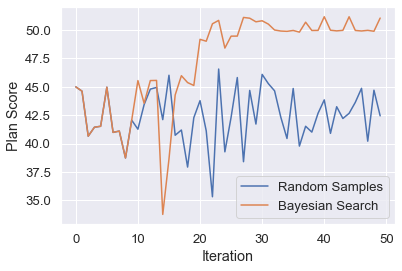

In [12]:
plt.plot(fun_rand)
plt.plot(fun_bayes)
plt.xlabel('Iteration')
plt.ylabel('Plan Score')
plt.legend(['Random Samples', 'Bayesian Search'])

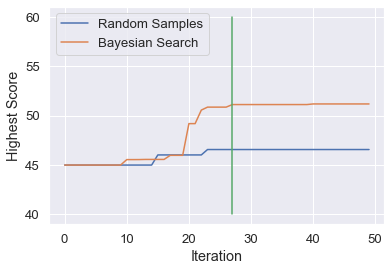

In [13]:
plt.plot(np.maximum.accumulate(fun_rand))
plt.plot(np.maximum.accumulate(fun_bayes))
plt.xlabel('Iteration')
plt.ylabel('Highest Score')
plt.legend(['Random Samples', 'Bayesian Search'])
plt.plot([27, 27], [40, 60])

In [33]:
labels = []
for ii in range(1, 7):
    roi = goals.iloc[ii]['Roi']
    goal = goals.iloc[ii]['Type']
    labels.append(f'{roi} {goal}')

In [40]:
x_rand.shape

(50, 6)

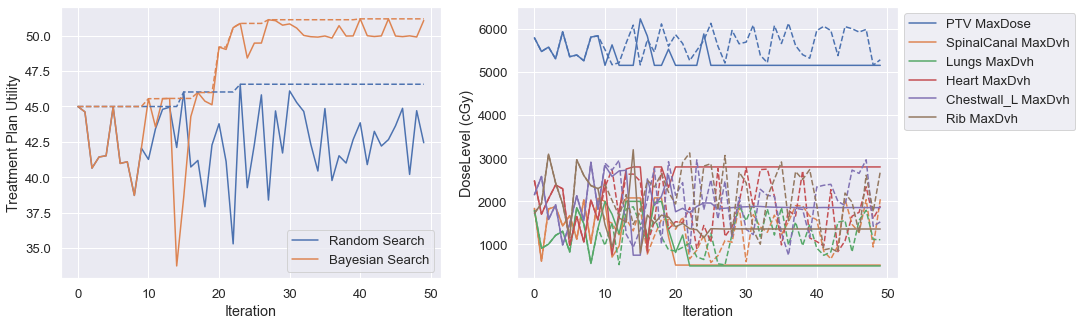

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# function value
ax[0].plot(fun_rand)
ax[0].plot(fun_bayes)
ax[0].plot(np.maximum.accumulate(fun_rand), '--', color=colors[0])
ax[0].plot(np.maximum.accumulate(fun_bayes), '--', color=colors[1])
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Treatment Plan Utility')
ax[0].legend(['Random Search', 'Bayesian Search'], loc='lower right')


# parameter value
handles = []
for ii in range(x_rand.shape[1]):
    ax[1].plot(x_rand[:, ii], '--', color=colors[ii])
    h, = ax[1].plot(x_bayes[:, ii], color=colors[ii])
    handles.append(h)
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('DoseLevel (cGy)')
plt.legend(handles=handles, labels=labels,
           bbox_to_anchor=(1, 1));

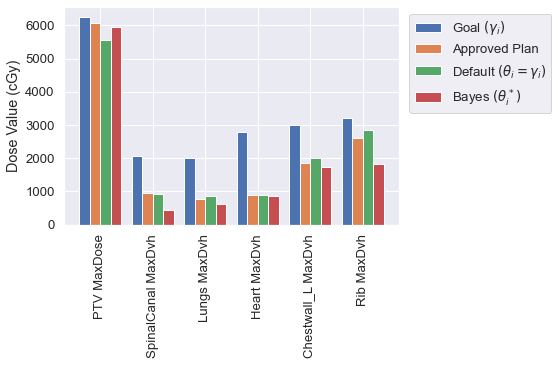

In [48]:
N = 6
men_means = (20, 35, 30, 35, 27)
women_means = (25, 32, 34, 20, 25)

ind = 1.5*np.arange(N) 
width = 0.3
plt.bar(ind - 3/2*width, list(pars_default['DoseLevel'])[1:], width, label='Goal $(\gamma_i)$')
plt.bar(ind - width/2, list(results_approved.iloc[0])[3:], width, label='Approved Plan')
plt.bar(ind + width/2, list(results_default.iloc[0])[3:], width, label=r'Default $(\theta_i = \gamma_i)$')
plt.bar(ind + 3/2*width, list(results_bayes.iloc[0])[3:], width, label=r'Bayes $(\theta_i^*)$')

plt.ylabel('Dose Value (cGy)')

plt.xticks(ind, labels, rotation=90)
plt.legend(bbox_to_anchor=(1.475, 1))
plt.show()

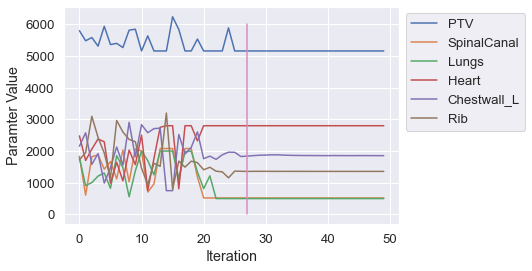

In [14]:
for ii in range(6):
    plt.plot([x_bayes[jj][ii] for jj in range(50)])
plt.xlabel('Iteration')
plt.ylabel('Paramter Value')
plt.legend(goals['Roi'][1:], bbox_to_anchor=(1, 1))
plt.plot([27, 27], [0, 6000])

In [52]:
funcs_full['DoseLevel'][2]

'[520, 2080]'

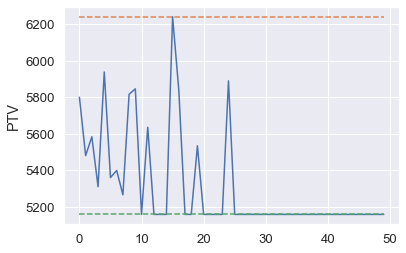

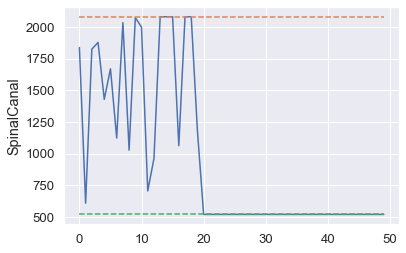

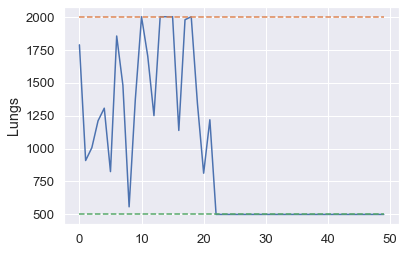

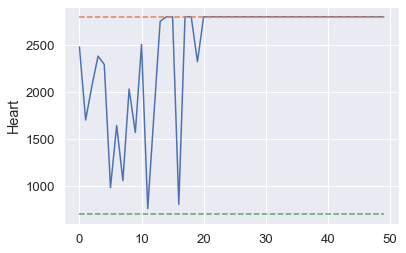

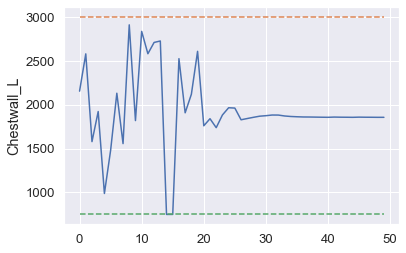

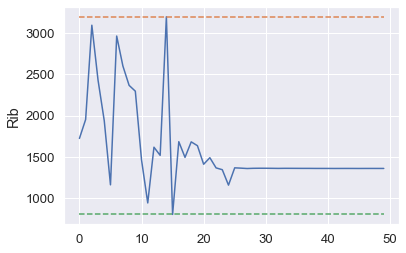

In [41]:
for ii in range(6):
    plt.figure()
    plt.plot([x_bayes[jj][ii] for jj in range(50)])
    plt.plot(np.arange(50), goals.iloc[ii + 1]['AcceptanceLevel']*np.ones(50), '--')
    if ii == 0:
        plt.plot(np.arange(50), 5160*np.ones(50), '--')
    else:
        plt.plot(np.arange(50), goals.iloc[ii + 1]['AcceptanceLevel']/4*np.ones(50), '--')
    plt.ylabel(goals.iloc[ii + 1]['Roi'])

In [17]:
# re-run everything with just half range???
# or re-run, but with normalization???

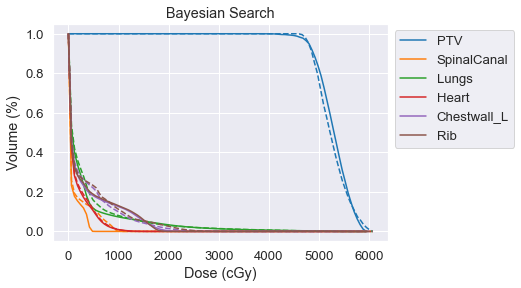

In [56]:
plot_dvh(dvh_bayes, 'Bayesian Search')

In [60]:
# Compare goal results
res_names = ['BS']
results = [results_bayes]
#results = [results_default, results_grid[results_grid['Sample'] == np.argmin(fun_grid)].reset_index(drop=True),
#           results_rand, results_bayes]

for goal, row in goals.iterrows():
    print(f"ROI: {row['Roi']}, Type: {row['Type']}")
    level = row['AcceptanceLevel']
    for ii in range(len(results)):
        res = results[ii][goal][0]
        diff_goal = 100*(res - level)/level
        app = results_approved[goal][0]
        diff_app = 100*(res - app)/app
        print(f'{res_names[ii]} Value: {res:.2f}, % Diff Goal: {diff_goal:.2f}, % Diff App: {diff_app:.2f}')
    print()

ROI: PTV, Type: MinDvh
BS Value: 4800.00, % Diff Goal: -0.00, % Diff App: -0.00

ROI: PTV, Type: MaxDose
BS Value: 5944.23, % Diff Goal: -4.74, % Diff App: -2.17

ROI: SpinalCanal, Type: MaxDvh
BS Value: 443.89, % Diff Goal: -78.66, % Diff App: -53.12

ROI: Lungs, Type: MaxDvh
BS Value: 609.37, % Diff Goal: -69.53, % Diff App: -22.23

ROI: Heart, Type: MaxDvh
BS Value: 861.75, % Diff Goal: -69.22, % Diff App: -3.09

ROI: Chestwall_L, Type: MaxDvh
BS Value: 1730.66, % Diff Goal: -42.31, % Diff App: -7.14

ROI: Rib, Type: MaxDvh
BS Value: 1836.88, % Diff Goal: -42.60, % Diff App: -29.92

